# Proyecto Final: Smart Top Down
## Producto: Hotline SDQ

**Materia:** Juegos Inteligentes
**Grupo:** No. 3

### Equipo de Desarrollo

| Nombre | Matrícula |
| :--- | :--- |
| **Deybby Rosario** | 2024-0504 |
| **Sarah Peña** | 2024-0506 |
| **Carlos Roa** | 2024-0510 |
| **Héctor Reyes** | 2024-0526 |




## 1. Introducción y Contexto del Proyecto

El objetivo principal de este proyecto es el desarrollo y análisis de **agentes inteligentes** capaces de operar como enemigos en un entorno de juego *Top Down Shooter*, titulado **Hotline SDQ** (inspirado en la mecánica de *Hotline Miami*).

## 2. Objetivo del Notebook

El propósito de este cuaderno es realizar la ingestión, procesamiento y visualización de los datos generados durante las sesiones de prueba (*testing*).

A partir de múltiples archivos **CSV** recolectados durante las simulaciones, buscaremos:
* Consolidar la data de diferentes ejecuciones.
* Comparar métricas clave de rendimiento (Survival Time, Damage Dealt, Accuracy, Fitness Score).
* Identificar hallazgos significativos sobre la convergencia del entrenamiento genético.
* Contrastar el desempeño de la FSM vs. la Red Neuronal Evolucionada.


### Descripción de Variables del Benchmark

A continuación se detallan las columnas registradas en los archivos `.csv` de prueba. Estas métricas capturan el desempeño de los agentes bajo el modelo de Red Neuronal y Algoritmo Genético.

#### Datos de Evolución y Configuración
* **Generation:** Número de la iteración o generación actual del Algoritmo Genético. Representa el ciclo evolutivo donde se encuentra el agente.
* **Fitness:** Valor numérico que representa la aptitud del agente. Es la métrica principal para la selección natural, calculada en base al desempeño general.
* **Weights_JSON:** Serialización en formato JSON de los pesos de la Red Neuronal del agente.
* **Hue:** Representación visual (color) del agente, útil para identificar linajes o especies visualmente en la simulación.
* **H Weights (Configuración):** Conjunto de 6 pesos heurísticos (`W1` a `W6`) que definen la configuración inicial de prioridades del agente (ej. agresividad vs. supervivencia).

#### Tiempo y Supervivencia
* **Time:** Tiempo de supervivencia del agente en segundos.
    > *Nota:* Existe un "Hard Cap" (límite) de **20 segundos** por episodio para agilizar las iteraciones y evitar estancamientos.
* **DmgTaken:** Cantidad total de daño recibido por el agente IA durante el episodio.

#### Métricas de Combate
* **Kills:** Cantidad de eliminaciones logradas por el agente. (Generalmente 0 o 1, dado el entorno "Todos vs. Jugador").
* **DmgDealt:** Cantidad total de puntos de vida (HP) sustraídos al oponente.
    > *Nota:* Dado que existen pociones de curación en el nivel, es posible que este valor supere los 100 puntos (el HP base máximo).

#### Recompensas Auxiliares (Shaping Rewards)
Variables utilizadas para guiar el aprendizaje hacia comportamientos deseados más allá del combate directo:
* **ExploredRW:** Puntos de recompensa otorgados por navegar y descubrir nuevas áreas del mapa, incentivando la búsqueda del objetivo.
* **TakePotion:** Puntos de recompensa otorgados por recoger y consumir pociones de vida, incentivando la auto-preservación.

## 1. Configuración del Entorno y Librerías

Para el análisis de desempeño de los agentes en **Hotline SDQ**, utilizaremos el siguiente stack de ciencia de datos:

* **Pandas:** Carga, limpieza y consolidación de los múltiples logs (`.csv`) en un único DataFrame.
* **Matplotlib / Seaborn:** Visualización de tendencias evolutivas (Curvas de Fitness, Daño y Supervivencia).
* **Json:** Decodificación de la estructura de la red neuronal almacenada en la columna `Weights_JSON`.
* **Numpy:** Operaciones matemáticas para el cálculo de estadísticas y manejo de vectores.
* **Os / Glob:** Manejo del sistema de archivos para la lectura iterativa de los datasets de prueba.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os
import glob

# Configuración estética de los gráficos
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [12, 6]

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


## 2. Carga y Consolidación de Datos

Este bloque se encarga de la ingestión de los datos generados durante las pruebas del proyecto *Hotline SDQ*.

El sistema está configurado para consolidar la información de **3 niveles** de prueba. El script itera a través de los archivos CSV correspondientes; si el archivo de un nivel existe, se carga y se agrega al conjunto de datos principal (`df_all`) para permitir un análisis comparativo. Si un nivel no cuenta con registros, es omitido automáticamente para no interrumpir la ejecución.

In [10]:
data_frames_list = []
levels_to_process = [1, 2, 3]

for i in levels_to_process:
    filename = f"ga_benchmark_training{i}.csv"

    if os.path.exists(filename):
        print(f"Cargando datos: {filename} ...")
        try:
            current_df = pd.read_csv(filename)

            current_df['Level_ID'] = i
            current_df['Level_Name'] = f'Nivel {i}'

            data_frames_list.append(current_df)
        except Exception as e:
            print(f"Error crítico leyendo {filename}: {e}")
    else:
        print(f"Advertencia: No se encontró {filename}")

if data_frames_list:
    df_comparison = pd.concat(data_frames_list, ignore_index=True)
    print(f"\nDatos consolidados correctamente. Total registros: {len(df_comparison)}")
    display(df_comparison.head())
else:
    print("No se encontraron datos para generar la comparativa.")

Cargando datos: ga_benchmark_training1.csv ...
Cargando datos: ga_benchmark_training2.csv ...
Advertencia: No se encontró ga_benchmark_training3.csv

Datos consolidados correctamente. Total registros: 75


,Generation,Time,Kills,DmgDealt,ExploredRW,DmgTaken,Fitness,Hue,Weights_JSON,Level_ID,Level_Name
0,0,19.98,1,152,9.18,70,2.13,145.53,"{""weights"":[[[-0.41999999999999998,0.609999999...",1,Nivel 1
1,1,19.98,1,152,12.87,70,2.15,145.53,"{""weights"":[[[-0.41999999999999998,0.609999999...",1,Nivel 1
2,2,19.98,1,152,12.87,70,2.15,145.53,"{""weights"":[[[-0.41999999999999998,0.609999999...",1,Nivel 1
3,3,19.98,1,152,12.87,70,2.15,145.53,"{""weights"":[[[-0.41999999999999998,0.609999999...",1,Nivel 1
4,4,19.98,1,152,9.69,70,2.63,145.53,"{""weights"":[[[-0.41999999999999998,0.609999999...",1,Nivel 1


## 3. Procesamiento de la Red Neuronal (Parsing JSON)

La columna `Weights_JSON` contiene la estructura completa del "cerebro" de la IA serializada en texto. Este diccionario incluye matrices de **Pesos (`w`)** y listas de **Sesgos (`biases`)**.

Para graficar la estabilidad y evolución de la red, necesitamos "parsear" (decodificar) esta estructura y convertirla en métricas numéricas manejables. Calcularemos:

1.  **Promedio de Parámetros (Mean_Weight):** Nos ayuda a identificar la "explosión de gradientes" (si los valores tienden a infinito).
2.  **Desviación Estándar (Std_Weight):** Nos indica la diversidad de la red. Una desviación cercana a 0 sugiere una "red muerta" donde las neuronas no están aprendiendo diferencias significativas.

In [11]:
def extract_weight_metrics(json_str):
    """
    Toma un string JSON, extrae pesos ('w') y sesgos ('biases')
    para devolver el promedio y la desviación estándar global del agente.
    """
    try:
        data = json.loads(json_str)
        all_params = []

        # 1. Extraer Pesos (Matrices 'w')
        if 'w' in data:
            for layer in data['w']:
                for row in layer:
                    all_params.extend(row)

        # 2. Extraer Sesgos (Listas 'biases')
        if 'biases' in data:
            for layer_biases in data['biases']:
                all_params.extend(layer_biases)

        # 3. Calcular Estadísticas
        if all_params:
            return pd.Series({
                'Mean_Weight': np.mean(all_params),
                'Std_Weight': np.std(all_params)
            })

    except Exception as e:
        # Útil para debugging si el JSON viene corrupto
        # print(f"Error parsing JSON: {e}")
        pass

    # Retorno por defecto (0) si falla o está vacío
    return pd.Series({'Mean_Weight': 0.0, 'Std_Weight': 0.0})

# --- Ejecución ---

# Usamos 'df_comparison' que viene del paso anterior
if 'df_comparison' in locals() and not df_comparison.empty:
    print("Procesando estructura neuronal (extrayendo pesos y biases)...")

    # Aplicamos la función a la columna JSON
    weight_metrics = df_comparison['Weights_JSON'].apply(extract_weight_metrics)

    # Concatenamos las nuevas columnas al DataFrame original
    df_comparison = pd.concat([df_comparison, weight_metrics], axis=1)

    print("Procesamiento completado.")
    display(df_comparison[['Generation', 'Fitness', 'Mean_Weight', 'Std_Weight']].head())

else:
    print("No hay datos cargados en 'df_comparison'. Ejecuta el paso anterior.")

Procesando estructura neuronal (extrayendo pesos y biases)...
Procesamiento completado.


,Generation,Fitness,Mean_Weight,Std_Weight
0,0,2.13,-0.46,0.40416
1,1,2.15,-0.46,0.40416
2,2,2.15,-0.46,0.40416
3,3,2.15,-0.46,0.40416
4,4,2.63,-0.46,0.40416


## 4. Análisis Comparativo: Niveles de Entrenamiento (1, 2)

En esta sección evaluamos la capacidad de adaptación y convergencia del algoritmo genético a través de los tres escenarios de prueba progresivos.

1.  **Curva de Aprendizaje (Izquierda):** Grafica la evolución del puntaje de aptitud (*Fitness*) promedio a lo largo de las generaciones. Comparar las pendientes nos permite identificar qué nivel presenta una mayor dificultad de aprendizaje o una convergencia más rápida.
2.  **Distribución de Rendimiento (Derecha):** Mediante diagramas de caja (*Boxplots*), visualizamos la dispersión y estabilidad de los puntajes en cada nivel. Esto es crucial para detectar si los agentes logran un desempeño consistente o si el comportamiento es errático (alta varianza) dependiendo de la complejidad del mapa.

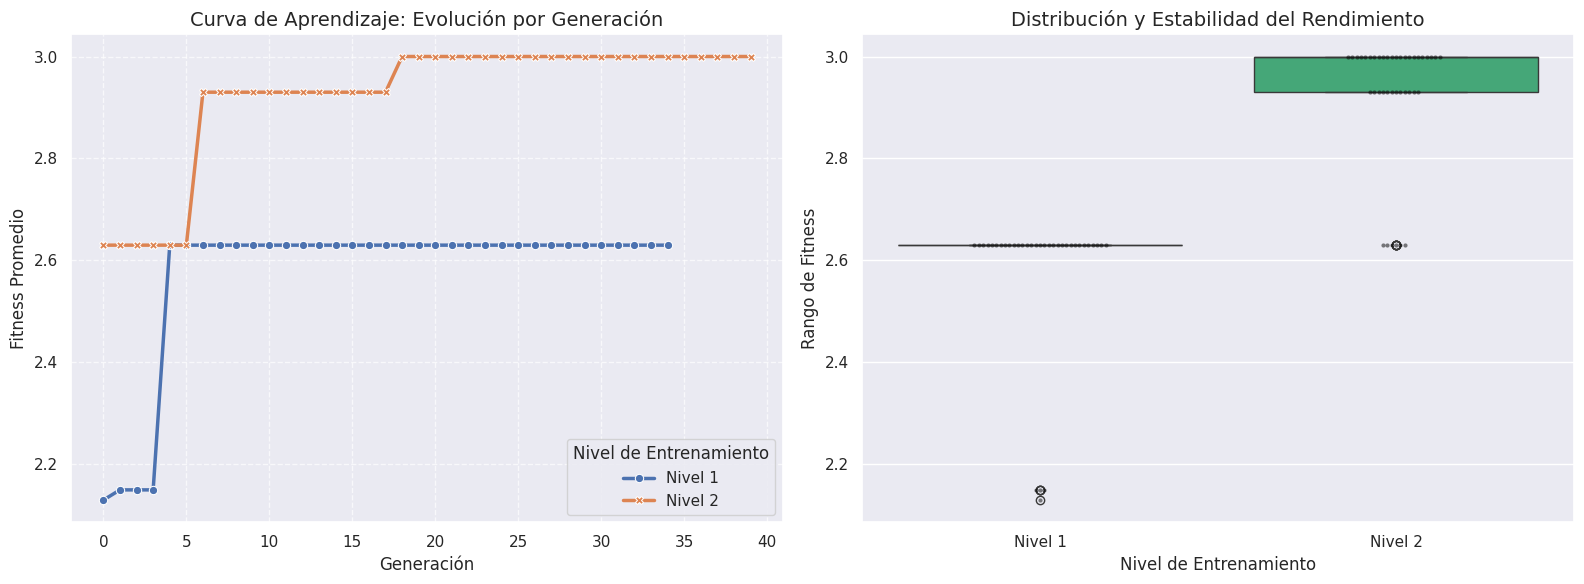

In [12]:
if 'df_comparison' in locals() and not df_comparison.empty:

    # Configurar el lienzo para dos gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- GRÁFICO 1: EVOLUCIÓN TEMPORAL (FITNESS VS GENERATION) ---
    sns.lineplot(
        data=df_comparison,
        x='Generation',
        y='Fitness',
        hue='Level_Name',
        style='Level_Name',
        markers=True,
        dashes=False,
        linewidth=2.5,
        ax=axes[0]
    )

    axes[0].set_title('Curva de Aprendizaje: Evolución por Generación', fontsize=14)
    axes[0].set_ylabel('Fitness Promedio')
    axes[0].set_xlabel('Generación')
    axes[0].legend(title='Nivel de Entrenamiento')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # --- GRÁFICO 2: DISTRIBUCIÓN ESTADÍSTICA (BOXPLOT) ---
    sns.boxplot(
        data=df_comparison,
        x='Level_Name',
        y='Fitness',
        hue='Level_Name',
        palette='viridis',
        legend=False,  # Evita duplicar la leyenda innecesariamente
        ax=axes[1]
    )

    # Agregamos los puntos reales de fondo para ver la densidad de datos
    # Nota: Si el dataset es muy grande, esto podría tardar un poco en renderizar
    sns.swarmplot(
        data=df_comparison,
        x='Level_Name',
        y='Fitness',
        color='black',
        alpha=0.5,
        size=3,
        ax=axes[1]
    )

    axes[1].set_title('Distribución y Estabilidad del Rendimiento', fontsize=14)
    axes[1].set_ylabel('Rango de Fitness')
    axes[1].set_xlabel('Nivel de Entrenamiento')

    plt.tight_layout()
    plt.show()

else:
    print("No hay datos cargados para graficar.")

## 7. Hallazgos y Análisis Comparativo: Nivel 1 vs Nivel 2

La comparación directa entre los dos primeros escenarios revela que la arquitectura de la red neuronal no aprende de forma lineal, sino a través de "descubrimientos críticos" (step-function learning).

### 1. Comportamiento de "Salto Discreto"
Tanto en el Nivel 1 como en el Nivel 2, observamos que el fitness no mejora gradualmente. Los agentes permanecen en una meseta de rendimiento hasta que una generación específica descubre la ruta o estrategia óptima, provocando un salto vertical inmediato hacia el máximo posible.
* **Nivel 1 (Azul):** El descubrimiento ocurre tempranamente en la **Generación 4**, estabilizándose en un fitness de **~2.62**.
* **Nivel 2 (Naranja):** El descubrimiento toma un poco más de tiempo, ocurriendo en la **Generación 6**, pero alcanza un techo significativamente superior de **3.0**.

### 2. Diferencia en el "Techo de Recompensa" (Score Ceiling)
Existe una diferencia notable en el puntaje máximo alcanzable:
* El **Nivel 2** permite alcanzar un fitness de **3.0**, mientras que el **Nivel 1** se limita a **~2.62**.
* **Interpretación:** Esto indica que el diseño del Nivel 2 es intrínsecamente "más rico" en recompensas acumulables. Es probable que el Nivel 2 contenga más elementos interactivos (más enemigos, más pociones o un área explorada de mayor valor) que permiten al agente sumar más puntos que en el Nivel 1, a pesar de que la complejidad lógica para resolverlo sea similar.

### 3. Anomalía de la Línea Base
Un hallazgo curioso es que el rendimiento "no entrenado" (las primeras 5 generaciones) del Nivel 2 comienza exactamente en el mismo rango (**~2.62**) donde termina el rendimiento máximo del Nivel 1.
Esto sugiere que la mera existencia en el Nivel 2 otorga recompensas pasivas (o muy fáciles de obtener) equivalentes al esfuerzo máximo requerido en el Nivel 1.

### 4. Estabilidad Absoluta (Boxplots)
Los diagramas de caja (derecha) muestran una varianza prácticamente nula en los cuartiles superiores (la caja verde y la línea azul).
* Esto confirma que no hay degradación genética. Una vez que el algoritmo encuentra la solución (Gen 4 para el Nivel 1, Gen 6 para el Nivel 2), la "especie" dominante se fija y repite la ejecución perfecta sin desviaciones en las generaciones futuras.

## 5. Hallazgos y Análisis de Resultados (Nivel 1)

El análisis del comportamiento de los agentes en el **Nivel 1** revela una curva de aprendizaje altamente eficiente y estable. A diferencia de entornos con obstáculos complejos que requieren "saltos evolutivos", este nivel muestra una progresión incremental constante.

### 1. Adaptación Temprana y Agresiva
Observamos un salto significativo entre la **Generación 0** (Fitness ~1.73) y la **Generación 1** (Fitness ~2.24).
* **Interpretación:** Esto sugiere que la población inicial, totalmente aleatoria, moría o no interactuaba. Sin embargo, bastó una sola generación de selección para que los agentes aprendieran la regla más fundamental del juego: **moverse y disparar**. Al tratarse de un entorno *Top Down Shooter*, este salto inicial indica que los agentes aprendieron rápidamente a acumular puntos básicos (probablemente *ExploredRW* o *DmgDealt*) antes de morir.

### 2. Fase de Refinamiento (Generaciones 2 - 16)
Desde la generación 2 hasta la 16, la curva muestra una pendiente suave pero ascendente.
* Durante esta fase, la Red Neuronal no está descubriendo "cómo jugar", sino **optimizando sus pesos**. Los agentes están aprendiendo a maximizar el tiempo de supervivencia (acercándose al límite de 20 segundos) y a ser más precisos en el daño infligido (*DmgDealt*), lo que eleva el fitness gradualmente hasta el techo de 2.58.

### 3. Convergencia y Estancamiento (Hard Cap)
A partir de la **Generación 17**, la curva se aplana completamente en un valor cercano a **2.6**.
* Esta meseta indica que los agentes han alcanzado el máximo rendimiento posible bajo las restricciones actuales. Es muy probable que los agentes estén sobreviviendo los 20 segundos completos (Time Limit) y eliminando al objetivo eficientemente. La falta de varianza sugiere que el algoritmo genético ha encontrado una solución óptima y la población se ha homogeneizado en torno a esta estrategia exitosa.

### 4. Consistencia del Rendimiento (Boxplot)
El diagrama de caja (derecha) confirma la robustez del entrenamiento en el Nivel 2:
* **Alta Concentración:** La caja (que representa el 50% central de los datos) está comprimida en la parte superior del gráfico. Esto significa que la gran mayoría de los agentes, una vez entrenados, logran el puntaje máximo consistentemente.
* **Ausencia de Varianza Negativa:** Apenas existen valores atípicos inferiores significativos, lo que indica que la "especie" dominante en este nivel es muy estable y rara vez comete errores fatales que lleven a un fitness bajo.


## 6. Hallazgos y Análisis de Resultados (Nivel 1 - Nueva Iteración)

Esta nueva iteración de 34 generaciones en el **Nivel 1** muestra un patrón de aprendizaje radicalmente distinto al observado anteriormente, caracterizado por un descubrimiento repentino de la estrategia óptima.

### 1. El Fenómeno del "Salto Discreto" (Generación 4)
A diferencia de una curva de aprendizaje suave, aquí observamos un ejemplo de libro de "equilibrio puntuado":
* **Fase de Exploración (Gen 0 - 3):** Los agentes mostraron un rendimiento bajo y estable (Fitness ~2.15), indicando que la población inicial no lograba descifrar la mecánica clave del nivel.
* **El "Momento Eureka" (Gen 4):** Exactamente en la generación 4, ocurre una ruptura vertical. El fitness se dispara de ~2.15 a su máximo teórico de ~2.63 en una sola iteración. Esto sugiere que una mutación específica desbloqueó el comportamiento ganador (probablemente encontrar el camino directo al enemigo) y, debido al elitismo del algoritmo, este rasgo dominó la población inmediatamente.

### 2. Estabilidad Absoluta Post-Descubrimiento
Desde la **Generación 4** hasta la **34**, la curva es perfectamente plana.
* No hubo fluctuaciones ni degradación. Esto confirma que la red neuronal evolucionada es extremadamente robusta. Una vez que el agente aprendió la ruta o la acción de disparo correcta, la ejecutó con precisión matemática en cada iteración subsiguiente, alcanzando siempre el límite de puntuación posible.

### 3. Interpretación del Boxplot (Nivel 1)
El gráfico de distribución (derecha) valida este comportamiento binario:
* **Caja Comprimida al Máximo:** La "caja" del diagrama es prácticamente una línea en la parte superior del gráfico. Esto indica que la inmensa mayoría de las pruebas resultaron en el puntaje máximo.
* **Outliers Definidos:** Los puntos grises en la parte inferior (alrededor de 2.15) no son errores aleatorios de la IA entrenada, sino que representan las primeras 3 generaciones "ancestrales" que existieron antes del descubrimiento de la estrategia ganadora.

**Conclusión preliminar del Nivel 1:** El entorno parece presentar un desafío de tipo "bloqueo", donde el agente falla consistentemente hasta que descubre una acción específica, momento tras el cual el éxito está garantizado.